<a href="https://colab.research.google.com/github/AkindeKadjo/ABL1_kinase_target_ligand_prediction/blob/main/Abl1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**By Akinde Kadjo**, 04/10/2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Introduction:** ABL1 ( or Tyrosine-protein kinase ABL) gene provides instructions for making a protein involved in many processes in cells throughout the body. In response to growth factors, cytokines, cell adhesion, DNA damage, oxidative stress, and other signals, ABL is activated to stimulate cell proliferation or differentiation, survival or death, retraction, or migration; according to [Wang.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3993570/#:~:text=The%20mammalian%20ABL1%20gene%20encodes,death%2C%20retraction%2C%20or%20migration.)

**Objective:** The goal of this project is to use the [DUDE-E](https://dude.docking.org/targets/abl1) data set for target against ABL1 to build a model that can accurately distinguish Active ligands from Decoy ligands (similar properties to actives but are known to be non-binders).

# Import and Data Loading

In [ ]:
#(skipped if already installed)
!pip install rdkit-pypi
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.1 MB/s eta 0:00:00


In [ ]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,roc_auc_score,PrecisionRecallDisplay, RocCurveDisplay,f1_score

from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw,rdMolDescriptors

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

import math
import scipy.stats as stats
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers

from keras.optimizers import RMSprop, Adam

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.cluster import MiniBatchKMeans

import lazypredict
from lazypredict.Supervised import LazyClassifier


In [ ]:
from keras.optimizers import RMSprop

# Functions

In order to keep a clean notebook, I'm storing all of the functions that I've created in this section. These functions pertain to data extraction, data cleaning, plots, prediction models and regression outputs.

## Data Extraction

In [ ]:
#Create a function to export the Physical properties of choice from the files files into a dataframe
def extract(file):
    suppl = Chem.SDMolSupplier(file)
    mol_len = len(suppl)
    df = pd.DataFrame()

    for i in range(mol_len):
        mol = suppl[i]
        if mol is not None:
            df.loc[i,'smiles'] = Chem.MolToSmiles(mol)
            df.loc[i,'chemblid'] = mol.GetProp('_Name')
            df.loc[i,'MW'] = Descriptors.ExactMolWt(mol)
            df.loc[i,'asphericity'] = rdMolDescriptors.CalcAsphericity(mol)
            df.loc[i,'eccentricity'] = rdMolDescriptors.CalcEccentricity(mol)
            df.loc[i,'Chi0n'] = rdMolDescriptors.CalcChi0n(mol)
            df.loc[i,'Chi0v'] = rdMolDescriptors.CalcChi0v(mol)
            df.loc[i,'Chi1n'] = rdMolDescriptors.CalcChi0n(mol)
            df.loc[i,'Chi1v'] = rdMolDescriptors.CalcChi0v(mol)
            df.loc[i,'Chi2n'] = rdMolDescriptors.CalcChi0n(mol)
            df.loc[i,'Chi2v'] = rdMolDescriptors.CalcChi0v(mol)
            df.loc[i,'NPR1'] = rdMolDescriptors.CalcNPR1(mol)
            df.loc[i,'NPR2'] = rdMolDescriptors.CalcNPR2(mol)
            df.loc[i,'PMI1'] = rdMolDescriptors.CalcPMI1(mol)
            df.loc[i,'PMI2'] = rdMolDescriptors.CalcPMI2(mol)
            df.loc[i,'PMI3'] = rdMolDescriptors.CalcPMI3(mol)
            df.loc[i,'SpherocityIndex'] = rdMolDescriptors.CalcSpherocityIndex(mol)
            df.loc[i,'sp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
            df.loc[i,'inertia'] = rdMolDescriptors.CalcInertialShapeFactor(mol)
            df.loc[i,'asa'] = rdMolDescriptors.CalcLabuteASA(mol)
            df.loc[i,'ar_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
            df.loc[i,'al_rings'] = rdMolDescriptors.CalcNumAliphaticRings(mol)
            df.loc[i,'stereoCenters'] = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
            df.loc[i,'atoms'] = rdMolDescriptors.CalcNumAtoms(mol)
            df.loc[i,'heavyatoms'] = rdMolDescriptors.CalcNumHeavyAtoms(mol)
            df.loc[i,'pbf'] = rdMolDescriptors.CalcPBF(mol)
            df.loc[i,'gyration'] = rdMolDescriptors.CalcRadiusOfGyration(mol)
            df.loc[i,'tpsa'] = rdMolDescriptors.CalcTPSA(mol)
            df.loc[i,'logp'] = Descriptors.MolLogP(mol)
            df.loc[i,'h_bond_donor'] = Descriptors.NumHDonors(mol)
            df.loc[i,'h_bond_acceptor'] = Descriptors.NumHAcceptors(mol)
            df.loc[i,'num_rotatable_bonds'] = Descriptors.NumRotatableBonds(mol)
            df.loc[i,'net_charge'] = Chem.GetFormalCharge(mol)
    print(df.shape)
    return df

## Plots

In [ ]:
##Creating a function for box plotting features per class
def feat_boxplot(plot_df):
    plot_per_row = 5
    y_list = list(plot_df.columns)
    y_len = len(y_list)
    rows = int((y_len/plot_per_row)+1)

    fig, axes = plt.subplots(rows,plot_per_row, figsize = ((3*plot_per_row), (3*rows)),constrained_layout=True)
    axes = axes.ravel()
    for i in range(y_len):
        sns.boxplot(ax = axes[i], x = plot_df['target'], y= plot_df[y_list[i]])
        axes[i].set_title(f'{y_list[i]}')
    return plt.show()

In [ ]:
##Creating a function for plotting histogram of the features
def feat_histplot(y_list, plot_df):
    y_len = len(y_list)
    plot_df_0 = plot_df.loc[plot_df['target'] == 0]
    plot_df_1 = plot_df.loc[plot_df['target'] == 1]
    fig, axes = plt.subplots(2,y_len, figsize = (30, 6),constrained_layout=True)
    axes = axes.ravel()
    for i in range(y_len):
        sns.histplot(ax = axes[i],  x= plot_df_1[y_list[i]],color='blue')
        axes[i].set_title(f'Active {y_list[i]}')
        sns.histplot(ax = axes[i+y_len],  x= plot_df_0[y_list[i]],color='red')
        axes[i+y_len].set_title(f'Decoy {y_list[i]}')
    return plt.show()

In [ ]:
##Creating a function for density plotting features per class
def feat_kdeplot(plot_df):
    plot_df.reset_index(drop=True, inplace=True)
    plot_per_row = 5
    y_list = list(plot_df.columns)
    y_len = len(y_list)
    rows = int((y_len/plot_per_row)+1)

    fig, axes = plt.subplots(rows,plot_per_row, figsize = ((3*plot_per_row), (3*rows)),constrained_layout=True)
    axes = axes.ravel()
    for i in range(y_len):
        sns.kdeplot(ax = axes[i], x= plot_df[y_list[i]], hue = plot_df['target'],common_norm = False)
        axes[i].set_title(f'{y_list[i]}')
    return plt.show()

## Data Cleaning

In [ ]:
def meaningful_df(dataframe, p_threshold):
    stat_list = []
    #splitting both classes
    df_1 = dataframe.loc[dataframe['target'] == 1]
    df_0 = dataframe.loc[dataframe['target'] == 0]

    for col in list(dataframe.columns):
        # Test for equal variance
        stat, p = levene(df_1[col], df_0[col])
        if p > 0.05:
            # Both groups have equal variance
            _, ps = stats.ttest_ind(df_1[col], df_0[col], equal_var = True)
            if ps > p_threshold:
                ak = 'they are statistically the same'
            else:
                stat_list.append(col)
        else:
            # Both groups do not have equal variance
            _, ps = stats.ttest_ind(df_1[col], df_0[col], equal_var = False)
            if ps > p_threshold:
                ak = 'they are statistically the same'
            else:
                stat_list.append(col)

    new_df = dataframe[stat_list]
    return new_df

In [ ]:
#keeping features highly correlated to the target
def corr_df(dataframe, target, threshold):
    corr = dataframe.corr()
    condition = (abs(corr[target]).sort_values(ascending = False))> threshold
    num_keep = condition.sum()
    features_kept = (condition.index)[0:num_keep]
    new_df = dataframe[features_kept]
    return new_df

In [ ]:
#keeping features highly correlated to the target
def nocolinear_df(dataframe, threshold):
    corr = dataframe.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    new_df = dataframe.drop(dataframe[to_drop], axis=1)
    return new_df

## Regression metrics

In [ ]:
#creating a data frame output of the metrics
def res_regression(model,xtest,ytest,xtrain,ytrain):
    """Output regression metrics for both the test and the train data"""
    ## Get Predictions
    test_pred, train_pred = (model.predict(xtest)), (model.predict(xtrain))
    #test metrics
    mse_test = mean_squared_error(ytest, test_pred)
    rmse_test = np.sqrt(mse_test).round(4)
    r2_test = r2_score(ytest, test_pred).round(4)
    res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
    #train metrics
    mse_train = mean_squared_error(ytrain, train_pred)
    rmse_train = np.sqrt(mse_train).round(4)
    r2_train = r2_score(ytrain, train_pred).round(4)
    res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
    res_df = pd.concat([res_df_test, res_df_train],axis = 1)

    print('---'*20)
    print(f"CLASSIFICATION REPORT")
    print('---'*20)
    print(f'Balanced accuracy: {round((balanced_accuracy_score(ytest, test_pred)), 4)}')
    fig, axes = plt.subplots(1,2, figsize=(10,3))
    ConfusionMatrixDisplay.from_predictions(ytest,test_pred, normalize='true',cmap='Blues', ax=axes[0])
    RocCurveDisplay.from_estimator(model, xtest, ytest,ax=axes[1])

    return res_df

In [ ]:
#creating a data frame output of the metrics without confusion metrics
def res_reg(model,xtest,ytest,xtrain,ytrain):
    """Output regression metrics for both the test and the train data"""
    ## Get Predictions
    test_pred, train_pred = (model.predict(xtest)), (model.predict(xtrain))
    #test metrics
    mse_test = mean_squared_error(ytest, test_pred)
    rmse_test = np.sqrt(mse_test).round(4)
    r2_test = r2_score(ytest, test_pred).round(4)
    res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
    #train metrics
    mse_train = mean_squared_error(ytrain, train_pred)
    rmse_train = np.sqrt(mse_train).round(4)
    r2_train = r2_score(ytrain, train_pred).round(4)
    res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
    res_df = pd.concat([res_df_test, res_df_train],axis = 1)
    return res_df

## Prediction Models

In [ ]:
def model_prediction(model):
    model = model
    scaler = StandardScaler()
    model_pipe = make_pipeline(scaler, model)
    model_pipe.fit(X_train, y_train)
    #Evaluating the model
    res = res_regression(model_pipe,X_test,y_test, X_train,y_train)
    return res

In [ ]:
def MLmodel_triangle(den, epoc,drop, reg1, reg2, lr, batch_size):
    input_shape = X_train.shape[1]
    model = Sequential()
    model.add(Dense(den, input_dim = input_shape, activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den*2), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den*4), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den*8), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))

    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(learning_rate=lr),
                  metrics=['mae'])
    # Fit our model
    history = model.fit(scaled_X_train, y_train,
                        batch_size = batch_size,
                        validation_data = (scaled_X_test, y_test),
                        epochs=epoc,verbose=0 )
    res = res_reg(model,scaled_X_test,y_test,scaled_X_train,y_train)

    test_pred = model.predict(scaled_X_test)
    assign = lambda x: 1 if x > 0.5 else 0
    test_pred = list(map(assign, test_pred))
    print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')

    fig, axes = plt.subplots(1,2, figsize=(10,3))
    ConfusionMatrixDisplay.from_predictions(y_test,test_pred, normalize='true',cmap='Blues', ax=axes[0])
    #RocCurveDisplay.from_estimator(model, scaled_X_test, y_test,ax=axes[1])

    # Visualize the loss
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend();
    return res

In [ ]:
def MLmodel_square(den, epoc,drop, reg1, reg2, lr, batch_size):
    input_shape = X_train.shape[1]
    model = Sequential()
    model.add(Dense(den, input_dim = input_shape, activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))

    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(learning_rate=lr),
                  metrics=['mae'])
    # Fit our model
    history = model.fit(scaled_X_train, y_train,
                        batch_size = batch_size,
                        validation_data = (scaled_X_test, y_test),
                        epochs=epoc,verbose=0 )
    res = res_reg(model,scaled_X_test,y_test,scaled_X_train,y_train)

    test_pred = model.predict(scaled_X_test)
    assign = lambda x: 1 if x > 0.5 else 0
    test_pred = list(map(assign, test_pred))
    print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')

    fig, axes = plt.subplots(1,2, figsize=(10,3))
    ConfusionMatrixDisplay.from_predictions(y_test,test_pred, normalize='true',cmap='Blues', ax=axes[0])
    #RocCurveDisplay.from_estimator(model, scaled_X_test, y_test,ax=axes[1])

    # Visualize the loss
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend();
    return res

In [ ]:
def MLmodel_2xsquare(den, epoc,drop, reg1, reg2, lr, batch_size):
    input_shape = X_train.shape[1]
    model = Sequential()
    model.add(Dense(den, input_dim = input_shape, activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))

    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(learning_rate=lr),
                  metrics=['mae'])
    # Fit our model
    history = model.fit(scaled_X_train, y_train,
                        batch_size = batch_size,
                        validation_data = (scaled_X_test, y_test),
                        epochs=epoc,verbose=0 )
    res = res_reg(model,scaled_X_test,y_test,scaled_X_train,y_train)

    test_pred = model.predict(scaled_X_test)
    assign = lambda x: 1 if x > 0.5 else 0
    test_pred = list(map(assign, test_pred))
    print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')

    fig, axes = plt.subplots(1,2, figsize=(10,3))
    ConfusionMatrixDisplay.from_predictions(y_test,test_pred, normalize='true',cmap='Blues', ax=axes[0])
    #RocCurveDisplay.from_estimator(model, scaled_X_test, y_test,ax=axes[1])

    # Visualize the loss
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend();
    return res

In [ ]:
def MLmodel_2xadam(den, epoc,drop, reg1, reg2, lr, batch_size):
    input_shape = X_train.shape[1]
    model = Sequential()
    model.add(Dense(den, input_dim = input_shape, activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))
    model.add(Dropout(drop))
    model.add(Dense((den), activation = 'relu',
                    kernel_regularizer = regularizers.l1_l2(l1 = reg1, l2 = reg2)))

    model.add(Dense(1, activation = 'tanh'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = Adam(learning_rate=lr),
                  metrics=['mae'])
    # Fit our model
    history = model.fit(scaled_X_train, y_train,
                        batch_size = batch_size,
                        validation_data = (scaled_X_test, y_test),
                        epochs=epoc,verbose=0 )
    res = res_reg(model,scaled_X_test,y_test,scaled_X_train,y_train)

    test_pred = model.predict(scaled_X_test)
    assign = lambda x: 1 if x > 0.5 else 0
    test_pred = list(map(assign, test_pred))
    print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')

    fig, axes = plt.subplots(1,2, figsize=(10,3))
    ConfusionMatrixDisplay.from_predictions(y_test,test_pred, normalize='true',cmap='Blues', ax=axes[0])
    #RocCurveDisplay.from_estimator(model, scaled_X_test, y_test,ax=axes[1])

    # Visualize the loss
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend();
    return res

# Data Extraction

In [ ]:
active_df = extract('actives_final.sdf')
active_df.head(2)

(295, 33)


,smiles,chemblid,MW,asphericity,eccentricity,Chi0n,Chi0v,Chi1n,Chi1v,Chi2n,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCC1,CHEMBL355330,280.13,0.28,0.93,11.53,11.53,11.53,11.53,11.53,...,37.00,21.00,0.44,3.38,76.96,3.11,2.00,5.00,2.00,0.00
1,COc1ccccc1Oc1ccc2n[nH]c(-c3nc4ccc(N5CCC([NH+]6...,CHEMBL211508,523.28,0.70,0.99,22.37,22.37,22.37,22.37,22.37,...,74.00,39.00,0.67,6.45,83.50,4.94,3.00,5.00,6.00,1.00


In [ ]:
decoy_df = extract('decoys_final.sdf')
decoy_df.head(2)

(10885, 33)


,smiles,chemblid,MW,asphericity,eccentricity,Chi0n,Chi0v,Chi1n,Chi1v,Chi2n,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,C[C@@H]1CCCC[C@@]12NC(=O)N(CC(=O)Nc1ccc(C(N)=O...,ZINC02649438,358.16,0.63,0.99,14.58,14.58,14.58,14.58,14.58,...,48.00,26.00,0.63,4.36,121.60,1.22,3.00,4.00,4.00,0.00
1,C=C1NN(c2nc3ccccc3s2)C(=O)[C@@H]1/C=N/C(CO)(CO)CO,ZINC01814196,362.10,0.62,0.99,13.29,14.11,13.29,14.11,13.29,...,43.00,25.00,0.30,4.33,118.28,0.06,4.00,8.00,6.00,0.00


In [ ]:
#Adding target column
active_df['target'] = 1
decoy_df['target'] = 0
ligands_df =  pd.concat([active_df, decoy_df]) #Concacenating both dfs
#deleting duplicated data and missing values
ligands_df = ligands_df.drop_duplicates()
ligands_df.dropna(inplace=True)
#moving forward with only numeric columns
ligands_df = ligands_df.drop(columns=['smiles','chemblid'])
ligands_df.sample(frac=1).reset_index(drop=True, inplace=True)

# Molecules Visualisation

Active molecule   vs    Decoy molecule


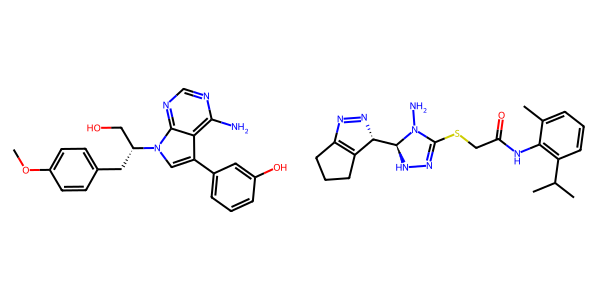

In [ ]:
mol1 = Chem.MolFromSmiles(active_df['smiles'][5])
mol2 = Chem.MolFromSmiles(decoy_df['smiles'][9])
mols = [mol1, mol2]
gimage = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,300))
print('Active molecule   vs    Decoy molecule')
gimage

# Data Cleaning

In [ ]:
print(f'Data Shape:{ligands_df.shape}')
#is the data balanced?
ligands_df['target'].value_counts(normalize=True)

Data Shape:(11174, 32)


0   0.97
1   0.03
Name: target, dtype: float64

## Keeping meaningfull features

We have 32 features which will need 2^32 data to train a model without overfitting. For 11k data, we'll need 13 features or less. So I'll try reducing 32 feautures to 13

In [ ]:
#keeping highly correlated features to the target
high_corr =corr_df(ligands_df, 'target', 0.05)
print(f'Df shape after high correlated selection: {high_corr.shape}')

#keeping feature where p-value between 1 and 0 is significantly low
p_df = meaningful_df(high_corr, 0.000001)
print(f'Df shape after low p-value selection: {p_df.shape}')

#Removing highly co-linear features
lean_df = nocolinear_df(p_df, 0.90)
print(f'Df shape after co-linear removal: {lean_df.shape}')

Df shape after high correlated selection: (11174, 19)
Df shape after low p-value selection: (11174, 19)
Df shape after co-linear removal: (11174, 13)


## Features Visualization

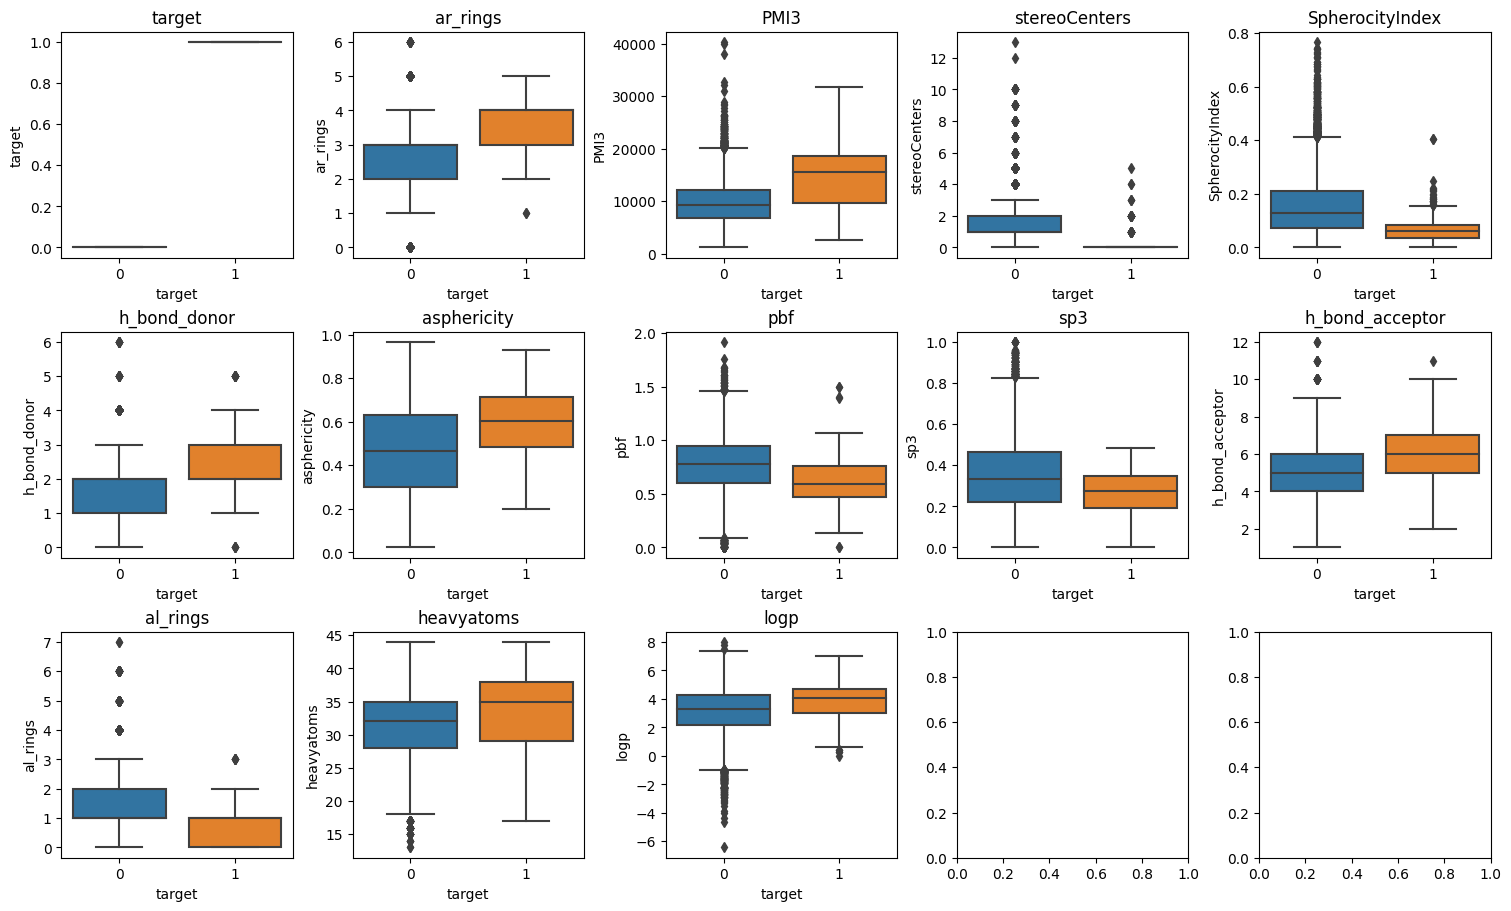

In [ ]:
feat_boxplot(lean_df)

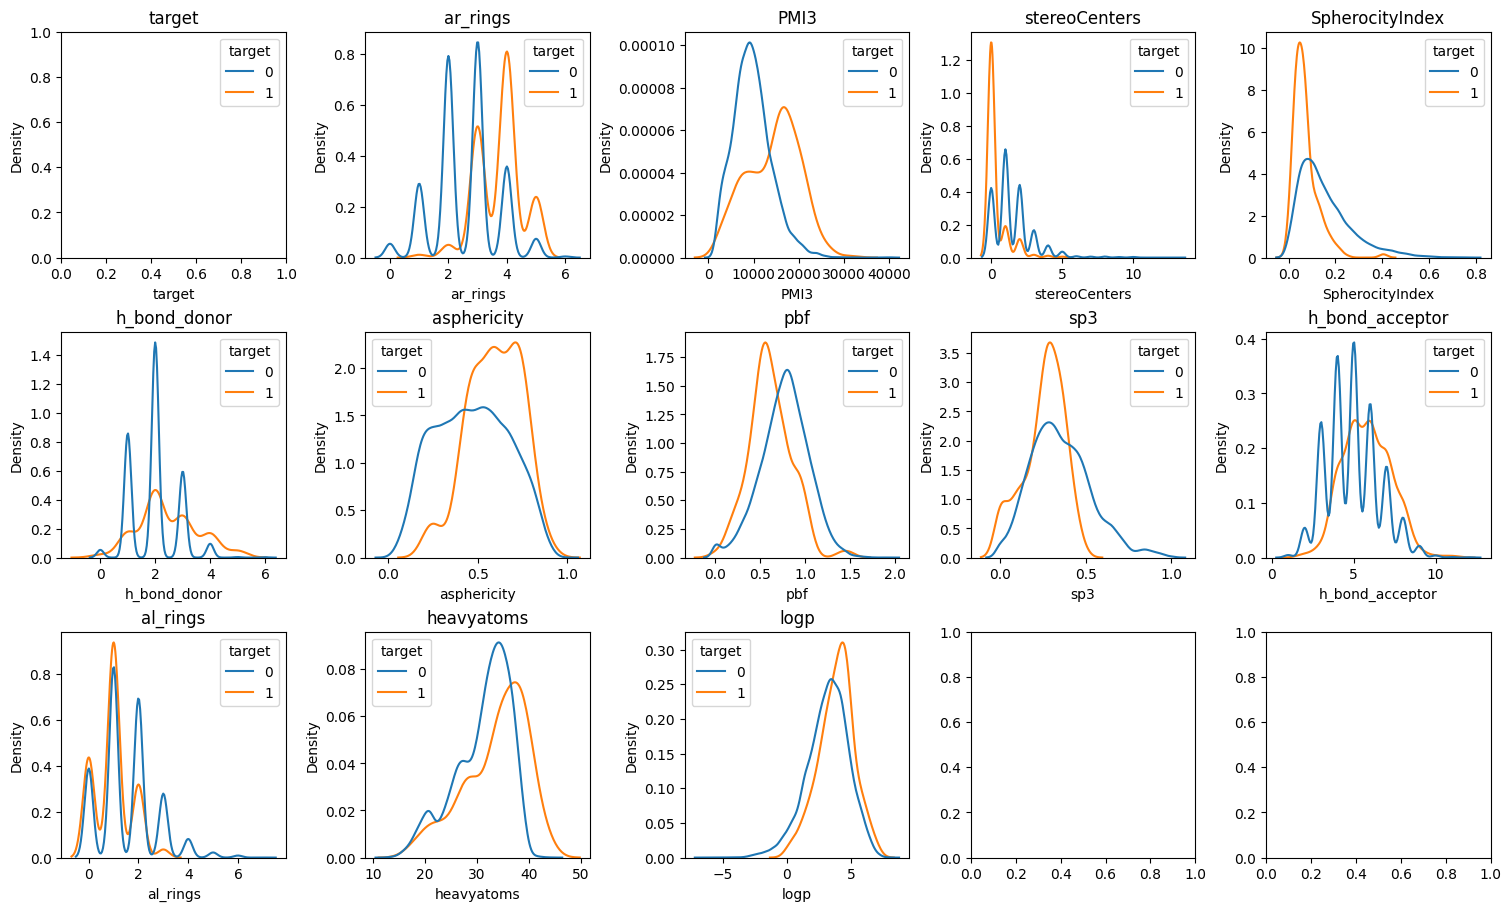

In [ ]:
feat_kdeplot(lean_df)

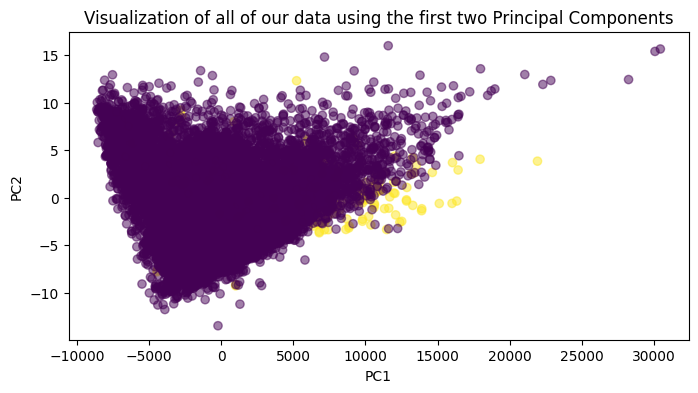

In [ ]:
# Instantiate, fit & transform data using PCA
V_df = corr_df(lean_df, 'target', 0.05)
X = V_df.drop(columns='target')

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
pca = PCA(n_components=2)
pcs = pca.fit_transform(V_df)

# Visualize the first 2 PCs
plt.figure(figsize = (8, 4))
plt.scatter(pcs[:,0], pcs[:,1],c= (V_df['target']), alpha=0.5)
plt.title('Visualization of all of our data using the first two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Basic ML Models

This dataset is unbalanced, so I'll have to account for that.

In [ ]:
#Data Splitting and Preprocessing
y = lean_df['target']
X = lean_df.drop(columns='target')
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

## Initial Data

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

100%|██████████| 29/29 [00:17<00:00,  1.68it/s]

[LightGBM] [Info] Number of positive: 233, number of negative: 8706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 8939, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026066 -> initscore=-3.620729
[LightGBM] [Info] Start training from score -3.620729


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.98,0.89,0.89,0.98,4.92
LabelPropagation,0.98,0.89,0.89,0.98,4.64
LGBMClassifier,0.99,0.82,0.82,0.99,0.21
XGBClassifier,0.99,0.82,0.82,0.99,0.18
DecisionTreeClassifier,0.97,0.81,0.81,0.98,0.15


 ## Oversampling minority Class

In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = SMOTE(random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [01:10<00:01,  1.65s/it]

[LightGBM] [Info] Number of positive: 8706, number of negative: 8706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 17412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.95,0.91,0.91,0.96,13.26
LabelSpreading,0.95,0.91,0.91,0.96,19.44
KNeighborsClassifier,0.92,0.91,0.91,0.94,0.73
SVC,0.93,0.88,0.88,0.95,5.29
ExtraTreesClassifier,0.99,0.86,0.86,0.99,1.39


In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = ADASYN(random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [01:09<00:01,  1.90s/it]

[LightGBM] [Info] Number of positive: 8689, number of negative: 8706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3049
[LightGBM] [Info] Number of data points in the train set: 17395, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499511 -> initscore=-0.001955
[LightGBM] [Info] Start training from score -0.001955


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.95,0.91,0.91,0.96,11.30
LabelSpreading,0.95,0.91,0.91,0.96,20.28
SVC,0.93,0.91,0.91,0.95,4.24
KNeighborsClassifier,0.91,0.90,0.90,0.94,0.72
ExtraTreesClassifier,0.99,0.86,0.86,0.99,0.92


In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = BorderlineSMOTE(random_state=0, kind="borderline-1")
X_train, y_train = over.fit_resample(X_train, y_train)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [01:04<00:01,  1.26s/it]

[LightGBM] [Info] Number of positive: 8706, number of negative: 8706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3049
[LightGBM] [Info] Number of data points in the train set: 17412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [01:04<00:00,  2.23s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.97,0.90,0.90,0.97,11.96
LabelSpreading,0.97,0.90,0.90,0.97,19.61
ExtraTreesClassifier,0.99,0.86,0.86,0.99,0.88
XGBClassifier,0.99,0.84,0.84,0.99,0.27
KNeighborsClassifier,0.93,0.82,0.82,0.95,0.46


In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = BorderlineSMOTE(random_state=0, kind="borderline-2")
X_train, y_train = over.fit_resample(X_train, y_train)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [01:07<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 8706, number of negative: 8706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3052
[LightGBM] [Info] Number of data points in the train set: 17412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.95,0.88,0.88,0.96,12.10
LabelSpreading,0.95,0.88,0.88,0.96,18.38
ExtraTreesClassifier,0.99,0.86,0.86,0.99,0.95
ExtraTreeClassifier,0.95,0.84,0.84,0.96,0.02
KNeighborsClassifier,0.91,0.83,0.83,0.93,0.48


In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = SVMSMOTE(random_state=0)
X_train, y_train = over.fit_resample(X_train, y_train)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [01:05<00:01,  1.72s/it]

[LightGBM] [Info] Number of positive: 8706, number of negative: 8706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3052
[LightGBM] [Info] Number of data points in the train set: 17412, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [01:05<00:00,  2.27s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.97,0.90,0.90,0.97,19.84
LabelPropagation,0.97,0.90,0.90,0.97,11.10
DecisionTreeClassifier,0.97,0.87,0.87,0.98,0.38
XGBClassifier,0.99,0.86,0.86,0.99,2.54
ExtraTreesClassifier,0.99,0.85,0.85,0.99,1.24


### Random Under-Sampling

In [ ]:
# reset X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train, y_train= rus.fit_resample(X_train, y_train)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

[LightGBM] [Info] Number of positive: 233, number of negative: 233
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 466, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.87,0.91,0.91,0.91,0.19
LGBMClassifier,0.86,0.90,0.90,0.90,0.12
XGBClassifier,0.85,0.90,0.90,0.90,0.10
RandomForestClassifier,0.86,0.89,0.89,0.90,0.26
BaggingClassifier,0.85,0.87,0.87,0.90,0.05


------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
Balanced accuracy: 0.901


,Test data,Training data
RMSE,0.38,0.00
R2,-4.57,1.00


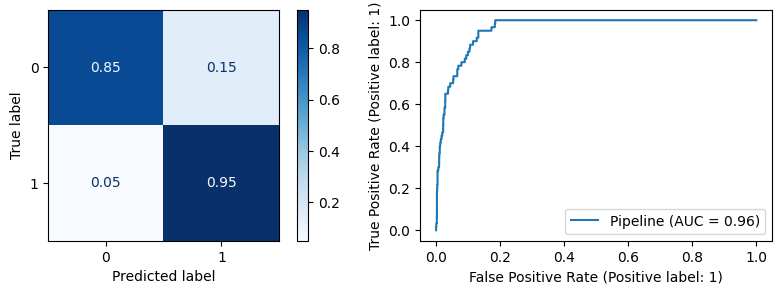

In [ ]:
#Picking best model
model_prediction(XGBClassifier())

The best model is xgbClassifier with random undersampling. I'm picking undersampling over oversampling because the former doesn't contain synthetic data.

# Deep Learning Models

## FNN

### Data as is

In [ ]:
y = lean_df['target']
X = lean_df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.7808


,Test data,Training data
RMSE,0.12,0.10
R2,0.44,0.64


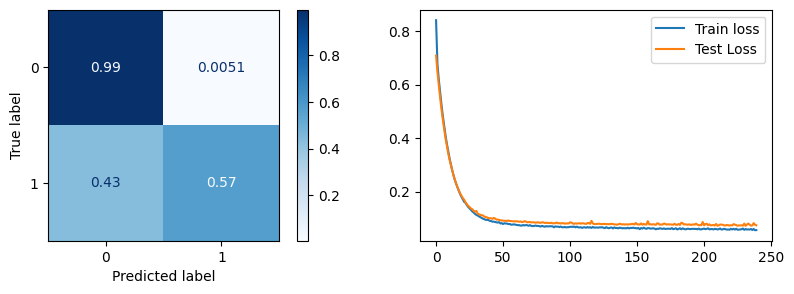

In [ ]:
MLmodel_triangle(64, 240, 0.2, 0.000, 0.001,0.001, 1000)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.8121


,Test data,Training data
RMSE,0.13,0.10
R2,0.38,0.64


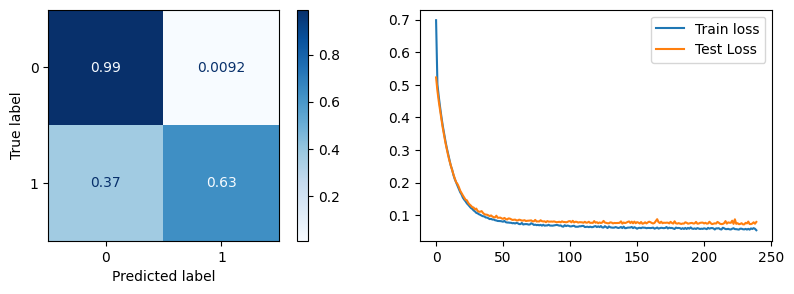

In [ ]:
MLmodel_square(128, 240, 0.2, 0.000, 0.001,0.001, 1000)

70/70 [==============================] - 0s 3ms/step
Balanced accuracy: 0.8378


,Test data,Training data
RMSE,0.11,0.07
R2,0.53,0.81


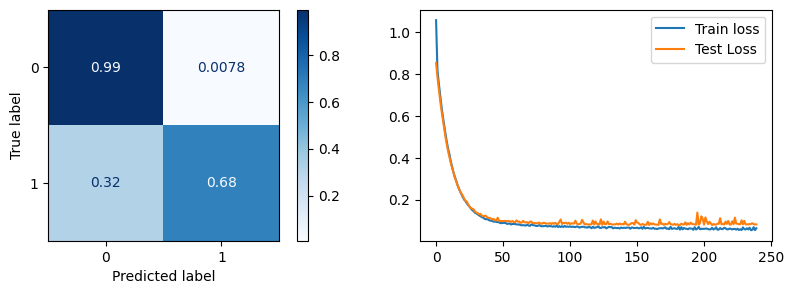

In [ ]:
MLmodel_2xsquare(128, 240, 0.2, 0.000, 0.001,0.001, 1000)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.8771


,Test data,Training data
RMSE,0.13,0.07
R2,0.38,0.78


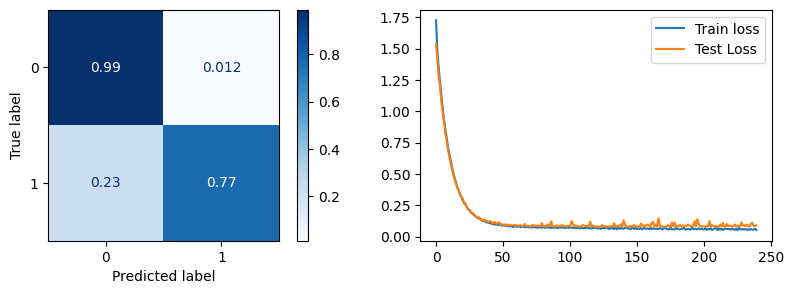

In [ ]:
MLmodel_2xsquare(256, 240, 0.2, 0.000, 0.001,0.001, 1000)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.8718


,Test data,Training data
RMSE,0.15,0.12
R2,0.15,0.40


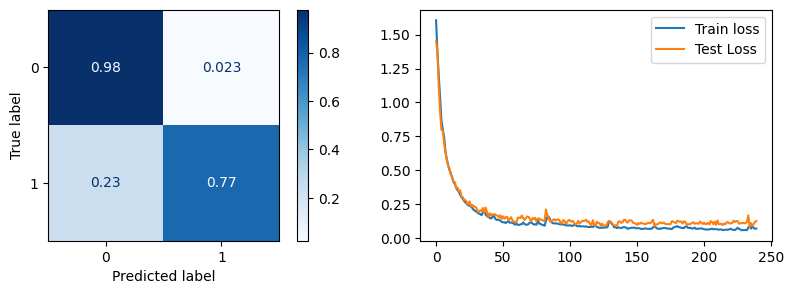

In [ ]:
MLmodel_2xadam(256, 240, 0.2, 0.000, 0.001,0.001, 500)

### Oversampling

In [ ]:
# reset X_train and y_train
y = lean_df['target']
X = lean_df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = SMOTE(random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.9114


,Test data,Training data
RMSE,0.16,0.05
R2,0.05,0.99


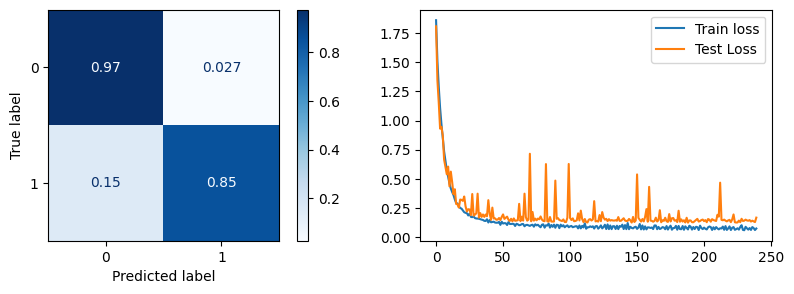

In [ ]:
MLmodel_2xsquare(256, 240, 0.2, 0.000, 0.001,0.001, 1000)

70/70 [==============================] - 0s 3ms/step
Balanced accuracy: 0.9158


,Test data,Training data
RMSE,0.13,0.03
R2,0.32,1.00


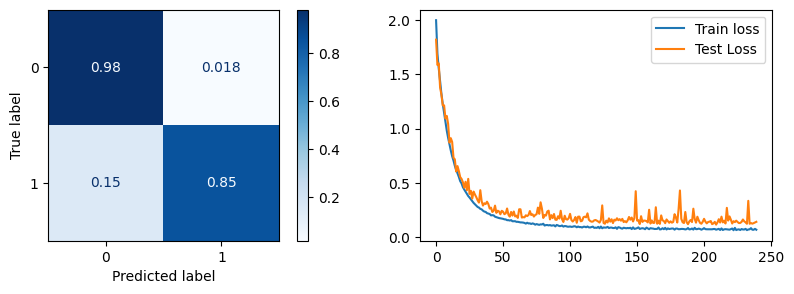

In [ ]:
MLmodel_2xsquare(256, 240, 0.3, 0.000, 0.001,0.0005, 1000)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.9198


,Test data,Training data
RMSE,0.19,0.10
R2,-0.41,0.96


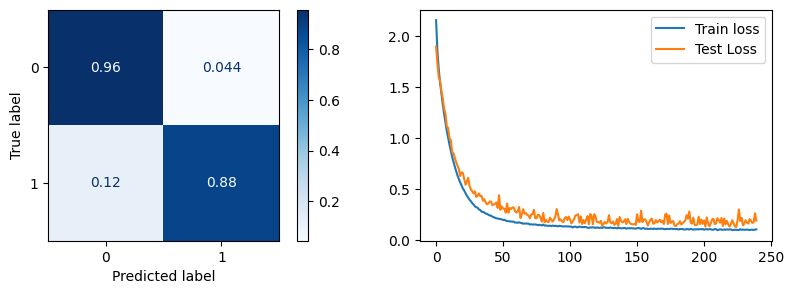

In [ ]:
MLmodel_2xsquare(256, 240, 0.6, 0.000, 0.001,0.0005, 1000)

### Random Undersampling

In [ ]:
# reset X_train and y_train
y = lean_df['target']
X = lean_df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Randomly over sample the minority class
over = RandomUnderSampler(random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

70/70 [==============================] - 0s 2ms/step
Balanced accuracy: 0.8856


,Test data,Training data
RMSE,0.33,0.06
R2,-3.12,0.99


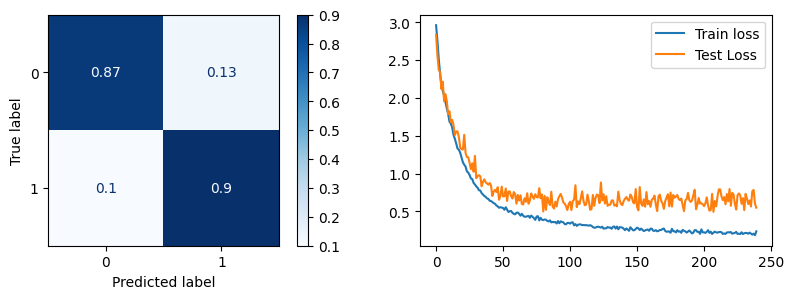

In [ ]:
MLmodel_2xsquare(128, 240, 0.3, 0.0001, 0.002,0.001, 100)

## GNN

# Conclusion

GNN model to be added later.